<a href="https://colab.research.google.com/github/KPAryan/js-quiz/blob/main/covid_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.17.0


In [ ]:
data_root='/content/Data'
path_positive_cases = os.path.join('/content/Data/Covid')
path_negative_cases = os.path.join('/content/Data/NoCovid')

In [ ]:
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [ ]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [ ]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 1252
Total Negative Cases Covid19 images: 1228


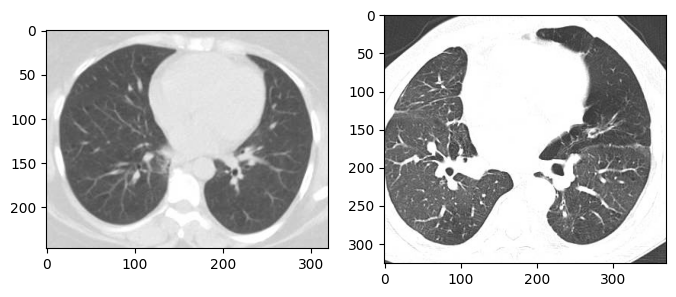

In [ ]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)


In [ ]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (326, 370, 3)
Image Non COVID Shape (247, 320, 3)


In [ ]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [ ]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing
test_ratio = 0.1


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set

    print(cases['class'], num_to_select)

    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

CT_COVID 125
CT_NonCOVID 122


In [ ]:
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [ ]:
total_train_covid = len(os.listdir('/content/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/content/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/content/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/content/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 1127
Train sets images Non COVID: 1106
Test sets images COVID: 125
Test sets images Non COVID: 122


In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_dir = os.path.join('/content/train')
test_dir = os.path.join('/content/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [ ]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 247 images belonging to 2 classes.


In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2233 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,641,441 (40.59 MB)

 Trainable params: 10,641,441 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use the correct import statement for ImageDataGenerator


def data_generator(generator):
    try:
        for data_batch, labels_batch in generator:
            yield data_batch, labels_batch
    except Exception as e:
        print(f"Error loading image: {e}")


history = model.fit(
    data_generator(train_data_gen),  # Wrap the generator with error handling
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=data_generator(test_data_gen),  # Wrap the validation generator as well
    validation_steps=total_test // batch_size
)

Epoch 1/15
 8/17 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4848 - loss: 2.5313 Error loading image: Truncated File Read


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 721ms/step - accuracy: 0.4898 - loss: 2.1836 - val_accuracy: 0.4922 - val_loss: 0.6919
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 913ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5210 - val_loss: 0.6932
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5391 - val_loss: 0.6946
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4706 - val_loss: 0.6903
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5126 - val_loss: 0.6929
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5469 - val_loss: 0.6952
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0000e

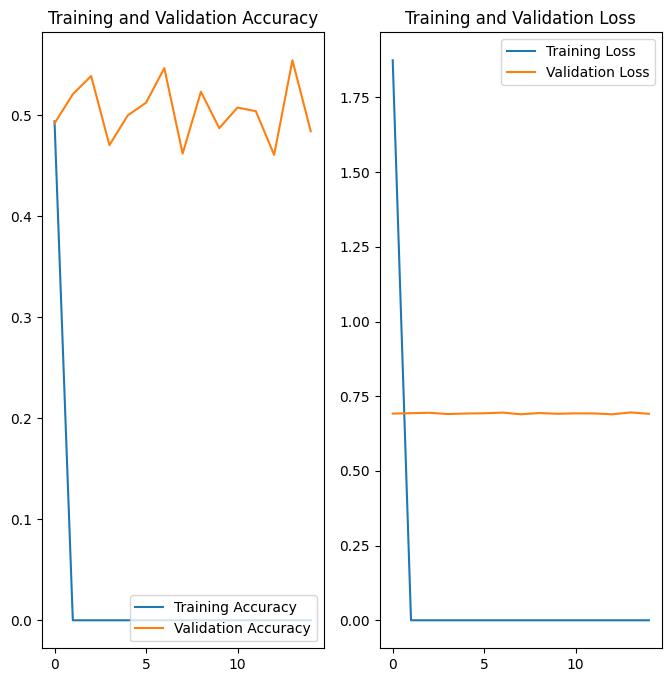

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install tensorflow.keras.applications

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.applications (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.applications


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import tensorflow as tf # Add this import statement

IMG_HEIGHT = 150 # Example height -  replace with your actual image height
IMG_WIDTH = 150 # Example width - replace with your actual image width

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Add this line
model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,219,713 (92.39 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = model.fit(
    data_generator(train_data_gen),
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=data_generator(test_data_gen),
    validation_steps=total_test // batch_size
)

Epoch 1/15
14/17 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5257 - loss: 2.3745Error loading image: Truncated File Read


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5308 - loss: 2.2162 - val_accuracy: 0.5703 - val_loss: 0.6178
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4370 - val_loss: 0.6803
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5234 - val_loss: 0.6516
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4874 - val_loss: 0.6439
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5078 - val_loss: 0.6352
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5042 - val_loss: 0.6615
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4922 - val_loss: 0.6676
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0000e+00 -

In [ ]:
# Get the training and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Print the accuracy scores
print("Training accuracy: ", acc[-1])
print("Validation accuracy: ", val_acc[-1])

Training accuracy:  0.0
Validation accuracy:  0.484375


In [ ]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2233 images belonging to 2 classes.


In [ ]:
history = model.fit(
    data_generator(train_data_gen),
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=data_generator(test_data_gen),
    validation_steps=total_test // batch_size
)

Epoch 1/15
 5/17 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5300 - loss: 0.6539Error loading image: Truncated File Read
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.5507 - loss: 0.6382 - val_accuracy: 0.6875 - val_loss: 0.6759
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6975 - val_loss: 0.6265
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7031 - val_loss: 0.6231
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6807 - val_loss: 0.6832
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6719 - val_loss: 0.6756
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 0.6267
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0000e+00 - loss: 0.